In [47]:
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from jupyterthemes import jtplot
import pickle

# import requests
# from bs4 import BeautifulSoup
import git

jtplot.style()

If the cell above gives any errors for missing packages, simply:
`!pip install PACKAGE`,

where `PACKAGE` is the missing package, e.g. for git: it's 

`!pip install GitPython`

# Update data

check remote git:
    
`git remote show origin`

In [222]:
git_dir = r'./COVID-19/'

g = git.cmd.Git(git_dir)
g.fetch()
g.pull()

'Updating d5eab1b..5e44031\nFast-forward\n .../csse_covid_19_daily_reports/03-15-2020.csv     | 259 ++++++\n .../time_series_19-covid-Confirmed.csv             | 896 +++++++++++----------\n .../time_series_19-covid-Deaths.csv                | 896 +++++++++++----------\n .../time_series_19-covid-Recovered.csv             | 896 +++++++++++----------\n 4 files changed, 1618 insertions(+), 1329 deletions(-)\n create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/03-15-2020.csv'

# Create the dataframe from the different files

In [287]:
ending = 'csv'
path_to_files = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'

all_paths = glob.glob(os.path.join(path_to_files, f'*.{ending}'))

In [288]:
all_paths

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv']

In [289]:
df_list = list()

for f in all_paths:
    foo = pd.read_csv(f)
    foo = pd.melt(foo, id_vars=[
                  'Province/State', 'Country/Region', 'Lat', 'Long'], var_name=['Date'])
    foo['Date'] = pd.to_datetime(foo['Date'])
    foo.columns = foo.columns.str.replace(
        'value', f.split("-")[-1].split(".")[0])
    foo['Province/State'].fillna(foo['Country/Region'], inplace=True)
    foo.set_index(['Province/State', 'Country/Region',
                   'Date', 'Lat', 'Long'], inplace=True)
    df_list.append(foo)

In [290]:
df = pd.concat(df_list, axis = 1).reset_index()
df.shape

(24300, 8)

In [291]:
# europe = dict()

# URL = "https://en.wikipedia.org/wiki/Member_state_of_the_European_Union"

# res = requests.get(URL).text
# soup = BeautifulSoup(res,'lxml')
# for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
#     data = items.find_all(['th','td'])
#     try:
#         country = data[0].a.text
#         europe[country] = 'EU'
#     except IndexError:
#         pass

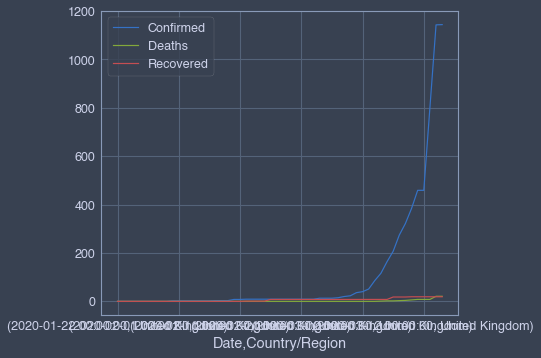

In [292]:
df[df['Country/Region'] == 'United Kingdom'].groupby(
    ['Date', 'Country/Region']).sum()[['Confirmed', 'Deaths', 'Recovered']].plot()

In [293]:
# Save to pickle

with open('country_continent.pickle', 'wb') as handle:
    pickle.dump(country_continent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [294]:
# Read pickle
with open('country_continent.pickle', 'rb') as handle:
    country_continent = pickle.load(handle)

In [295]:
df2 = df.copy()
df2['Date_1'] = df2['Date'] + pd.Timedelta(days=1)
df2.rename(columns={'Confirmed': 'Confrimed_1',
                    'Deaths': 'Deaths_1',
                    'Recovered': 'Recovered_1',
                    'Date': 'Date_Minus_1'}, inplace=True)

In [296]:
df3 = df.merge(df2[['Province/State',
                    'Country/Region',
                    'Confrimed_1',
                    'Deaths_1',
                    'Recovered_1',
                    'Date_1',
                    'Date_Minus_1']], how='left',
               left_on=['Province/State', 'Country/Region', 'Date'],
               right_on=['Province/State', 'Country/Region', 'Date_1'])

In [297]:
df3['ConfirmedDaily'] = df3['Confirmed'] - df3['Confrimed_1']
df3['DeathsDaily'] = df3['Deaths'] - df3['Deaths_1']
df3['RecoveredDaily'] = df3['Recovered'] - df3['Recovered_1']

In [298]:
df3['ConfirmedDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Confirmed']
df3['DeathsDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Deaths']
df3['RecoveredDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Recovered']

del df3['Confrimed_1']
del df3['Deaths_1']
del df3['Recovered_1']
del df3['Date_1']
del df3['Date_Minus_1']

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [299]:
df3.DeathsDaily.sum(), df3.ConfirmedDaily.sum(), df3.RecoveredDaily.sum()

(6066.0, 162721.0, 75620.0)

In [300]:
df3['MonthYear'] = df3['Date'].dt.strftime('%b-%Y')

In [301]:
df3['Continent'] = df3['Country/Region'].map(country_continent)

In [302]:
if len(df3[df3['Continent'].isna()]) == 0:
    print('All good')
else:
    print('Check it')

All good


In [303]:
df3['DeathRate'] = df3['Deaths'] / df3['Confirmed']
df3['RecoveredRate'] = df3['Recovered'] / df3['Confirmed']

In [304]:
df3.head()

,Province/State,Country/Region,Date,Lat,Long,Recovered,Deaths,Confirmed,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
0,"Adams, IN",US,2020-01-22,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
1,"Adams, IN",US,2020-01-23,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
2,"Adams, IN",US,2020-01-24,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
3,"Adams, IN",US,2020-01-25,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
4,"Adams, IN",US,2020-01-26,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN


# Plots

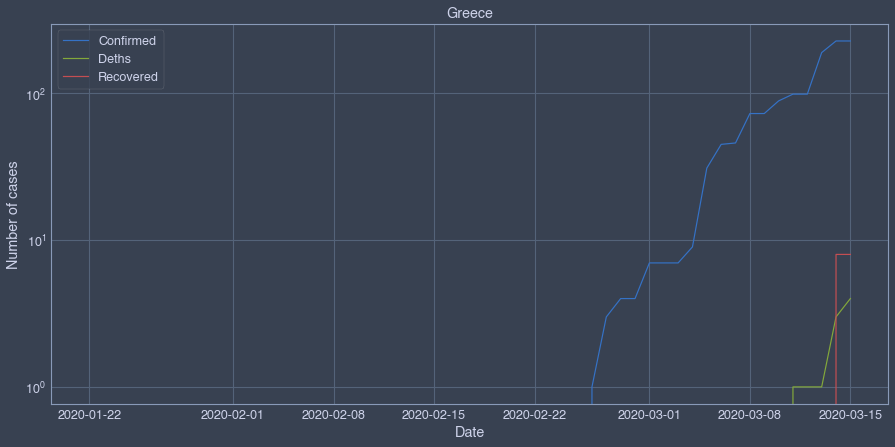

In [305]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

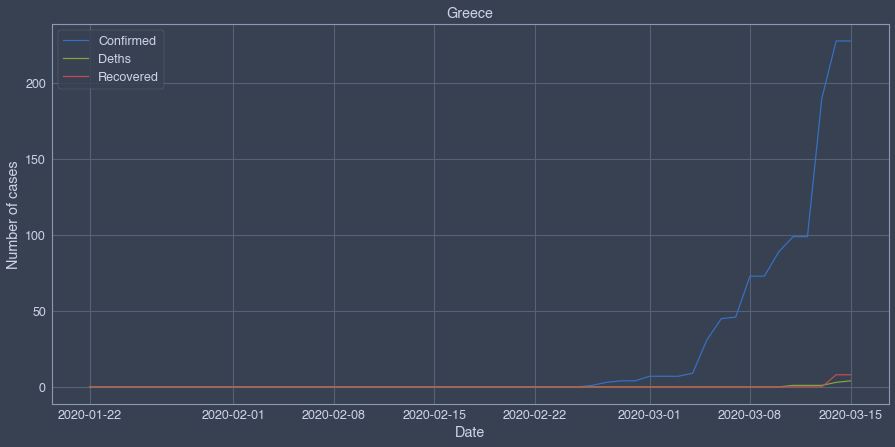

In [306]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

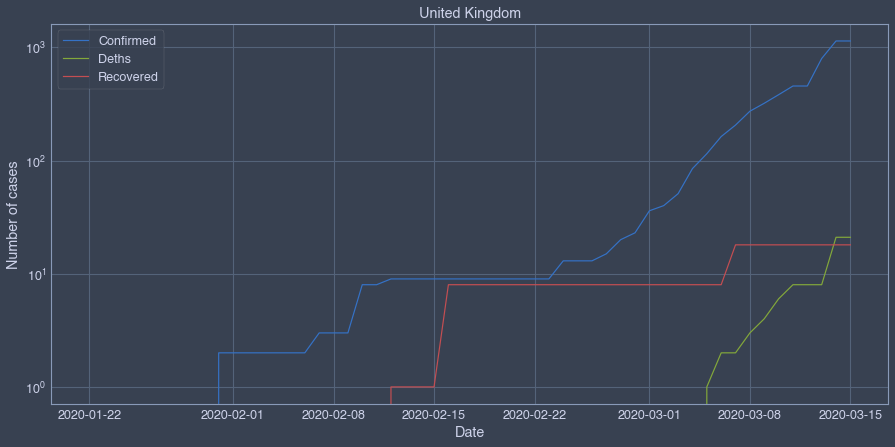

In [307]:
c = 'United Kingdom'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

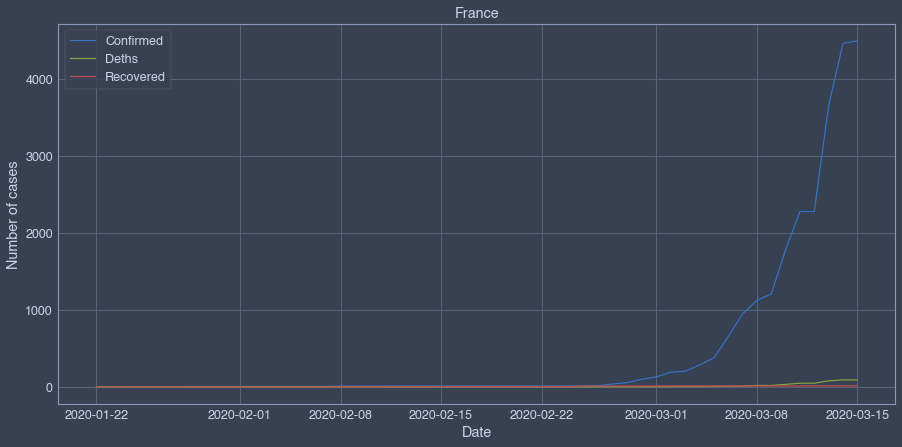

In [308]:
c = 'France'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

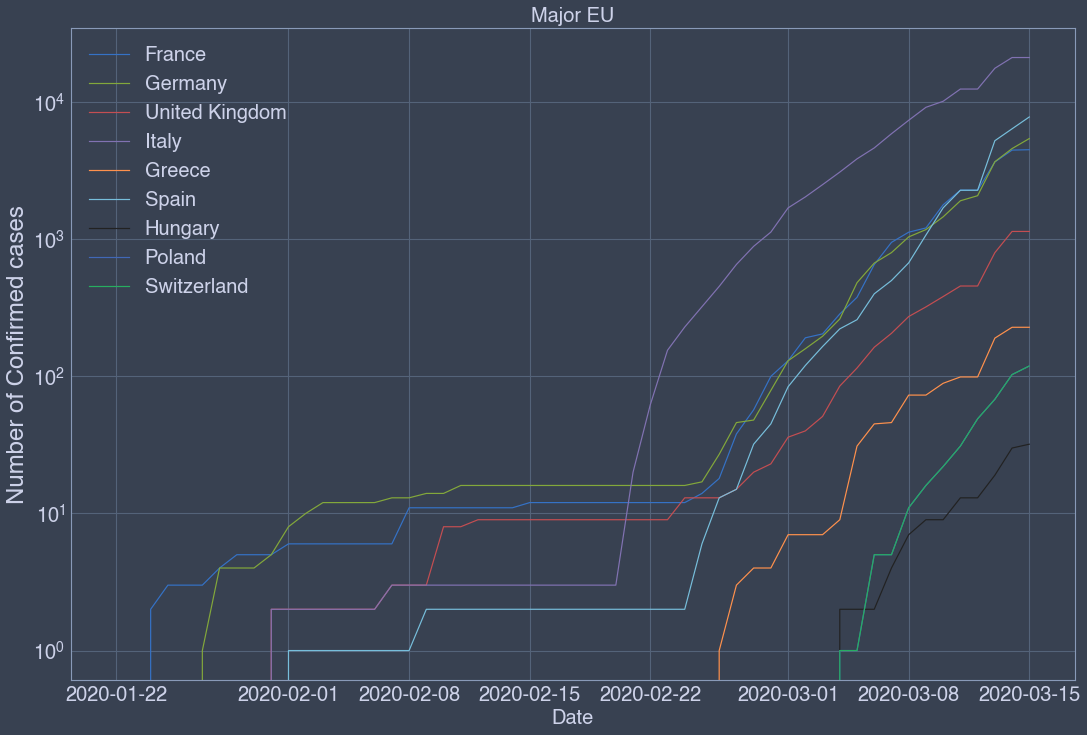

In [336]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']
y9 = df3[df3['Province/State'] == 'Switzerland']['Confirmed']




plt.figure(figsize = (18, 12))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y8, label = 'Switzerland')


plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Confirmed cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_confirmed.png', dpi = 600, bbox_inches= 'tight')

plt.show()

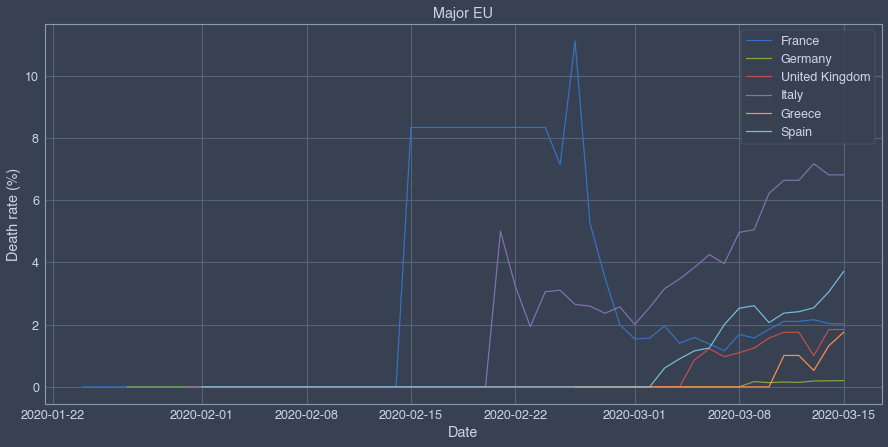

In [310]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['DeathRate'] * 100
y2 = df3[df3['Province/State'] == 'Germany']['DeathRate'] * 100
y3 = df3[df3['Province/State'] == 'United Kingdom']['DeathRate'] * 100
y4 = df3[df3['Province/State'] == 'Italy']['DeathRate'] * 100
y5 = df3[df3['Province/State'] == 'Greece']['DeathRate'] * 100
y6 = df3[df3['Province/State'] == 'Spain']['DeathRate'] * 100




plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'France')
plt.plot(x, y2, label = 'Germany')
plt.plot(x, y3, label = 'United Kingdom')
plt.plot(x, y4, label = 'Italy')
plt.plot(x, y5, label = 'Greece')
plt.plot(x, y6, label = 'Spain')

plt.ylabel('Death rate (%)')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

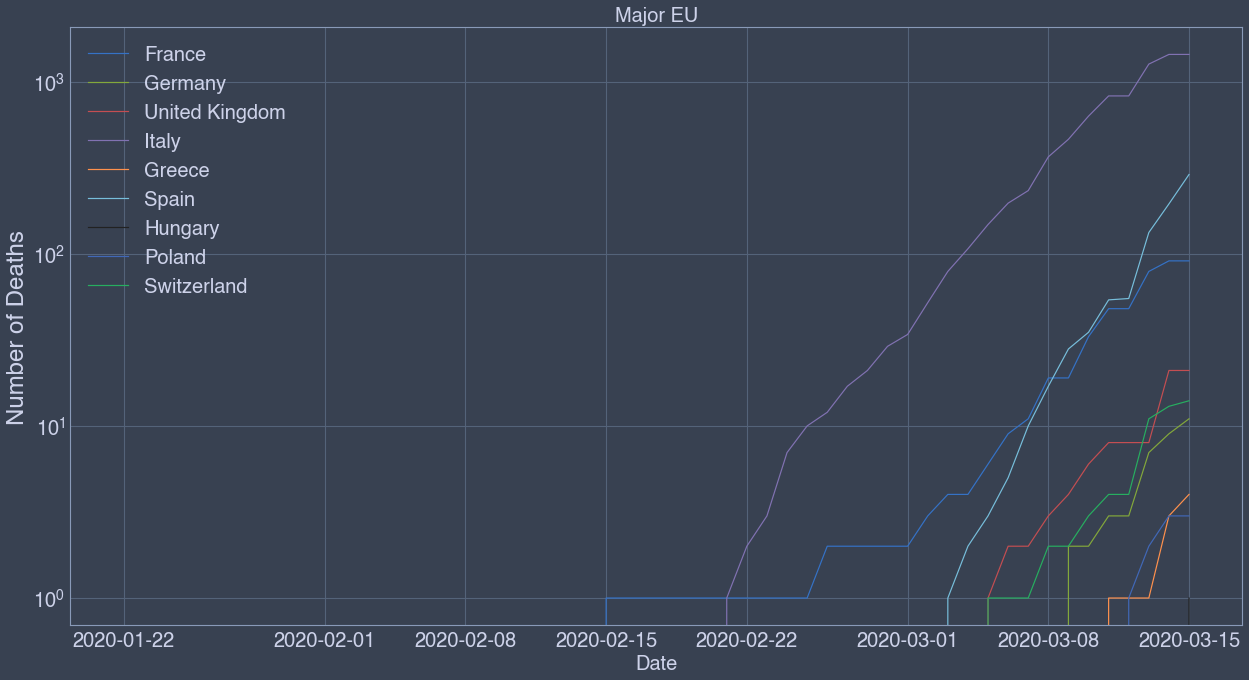

In [335]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Deaths']
y2 = df3[df3['Province/State'] == 'Germany']['Deaths']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y4 = df3[df3['Province/State'] == 'Italy']['Deaths']
y5 = df3[df3['Province/State'] == 'Greece']['Deaths']
y6 = df3[df3['Province/State'] == 'Spain']['Deaths']
y7 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y8 = df3[df3['Province/State'] == 'Poland']['Deaths']
y9 = df3[df3['Province/State'] == 'Switzerland']['Deaths']



plt.figure(figsize = (21, 11))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y9, label = 'Switzerland')

plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Deaths', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

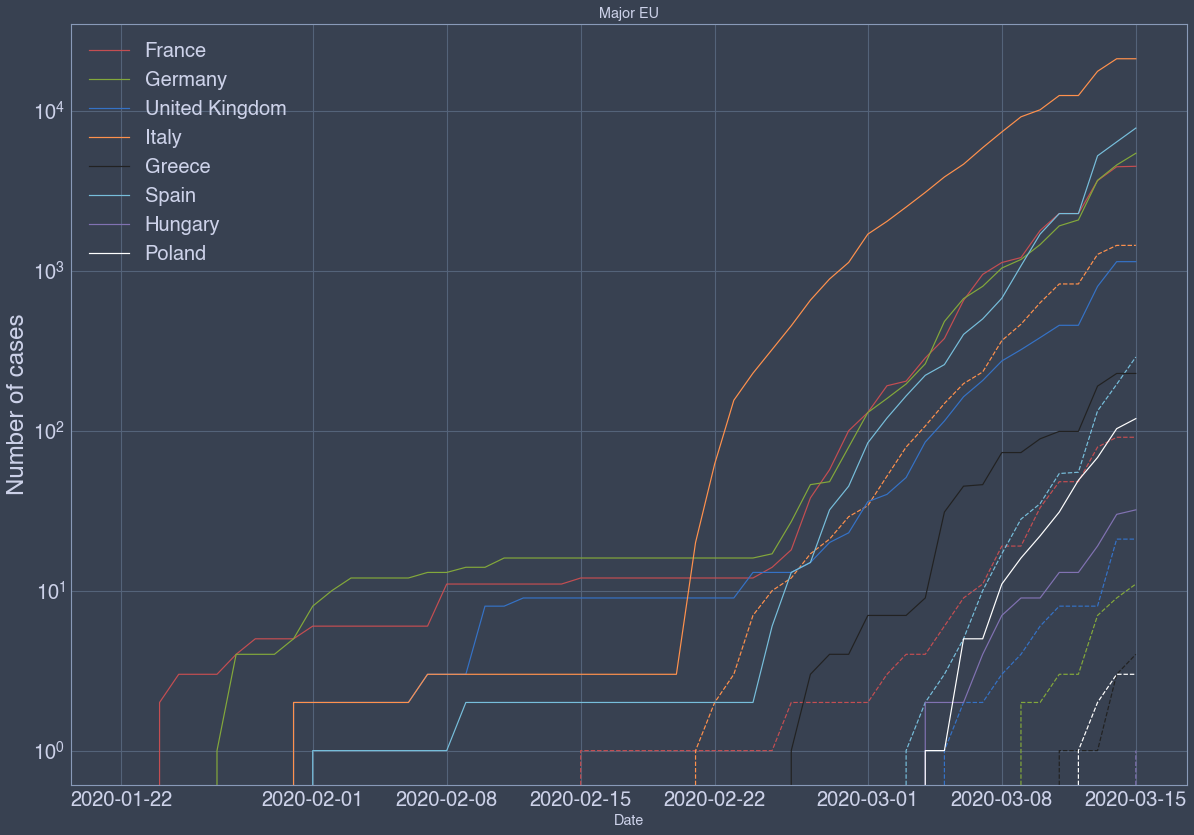

In [312]:
plt.figure(figsize = (20, 14))
x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']

y12 = df3[df3['Province/State'] == 'France']['Deaths']
y22 = df3[df3['Province/State'] == 'Germany']['Deaths']
y32 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y42 = df3[df3['Province/State'] == 'Italy']['Deaths']
y52 = df3[df3['Province/State'] == 'Greece']['Deaths']
y62 = df3[df3['Province/State'] == 'Spain']['Deaths']
y72 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y82 = df3[df3['Province/State'] == 'Poland']['Deaths']


plt.semilogy(x, y12, '--r')
plt.semilogy(x, y22, '--g')
plt.semilogy(x, y32, '--b')
plt.semilogy(x, y42, '--y')
plt.semilogy(x, y52, '--k')
plt.semilogy(x, y62, '--c')
plt.semilogy(x, y72, '--m')
plt.semilogy(x, y82, '--w')

plt.semilogy(x, y1, '-r', label = 'France')
plt.semilogy(x, y2, '-g', label = 'Germany')
plt.semilogy(x, y3, '-b', label = 'United Kingdom')
plt.semilogy(x, y4, '-y', label = 'Italy')
plt.semilogy(x, y5, '-k', label = 'Greece')
plt.semilogy(x, y6, '-c', label = 'Spain')
plt.semilogy(x, y7, '-m', label = 'Hungary')
plt.semilogy(x, y8, '-w', label = 'Poland')

plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.title('Major EU')
plt.ylabel('Number of cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.show()

In [313]:
df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()

,Date,Lat,Long,Recovered,Deaths,Confirmed,ConfirmedDaily,DeathsDaily,RecoveredDaily,DeathRate,RecoveredRate
0,2020-01-22,1083.3367,3684.4197,28,17,548,548.0,17.0,28.0,0.038288,0.063063
1,2020-01-23,1083.3367,3684.4197,30,18,643,95.0,1.0,2.0,1.038288,0.125563
2,2020-01-24,1083.3367,3684.4197,36,26,920,277.0,8.0,6.0,0.793716,0.195236
3,2020-01-25,1083.3367,3684.4197,39,42,1406,486.0,16.0,3.0,0.288674,0.218459
4,2020-01-26,1083.3367,3684.4197,49,56,2075,669.0,14.0,10.0,0.229787,0.152046
5,2020-01-27,1083.3367,3684.4197,58,82,2877,802.0,26.0,9.0,0.226066,0.196584
6,2020-01-28,1083.3367,3684.4197,101,131,5509,2632.0,49.0,43.0,0.152871,0.244761
7,2020-01-29,1083.3367,3684.4197,120,133,6087,578.0,2.0,19.0,0.143970,0.428728
8,2020-01-30,1083.3367,3684.4197,135,171,8141,2054.0,38.0,15.0,0.147556,0.472681
9,2020-01-31,1083.3367,3684.4197,214,213,9802,1661.0,42.0,79.0,0.126393,0.576703


In [314]:
df3.to_csv('data_v0.4.csv')

In [315]:
foo = df3.groupby(['Continent', 'Date']).sum().reset_index()

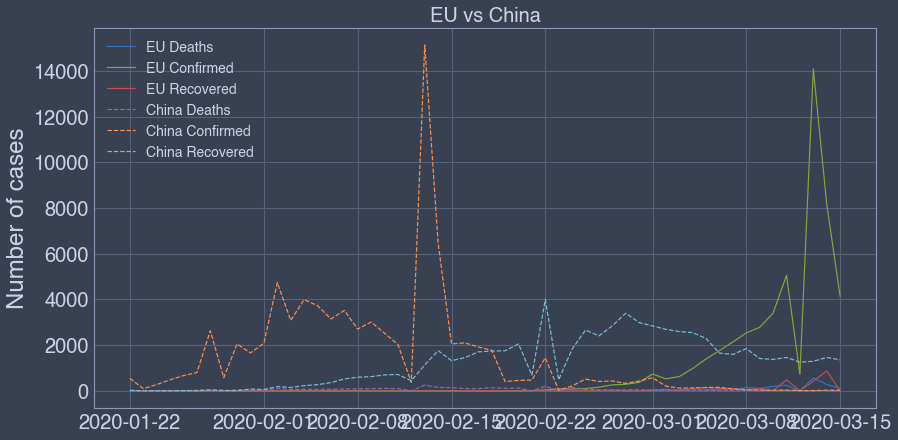

In [316]:
plt.figure(figsize=(14, 7))
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['DeathsDaily'], label='EU Deaths')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['ConfirmedDaily'], label='EU Confirmed')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['RecoveredDaily'], label='EU Recovered')

plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['DeathsDaily'],
         '--', label='China Deaths')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['ConfirmedDaily'],
         '--', label='China Confirmed')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['RecoveredDaily'],
         '--', label='China Recovered')

plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

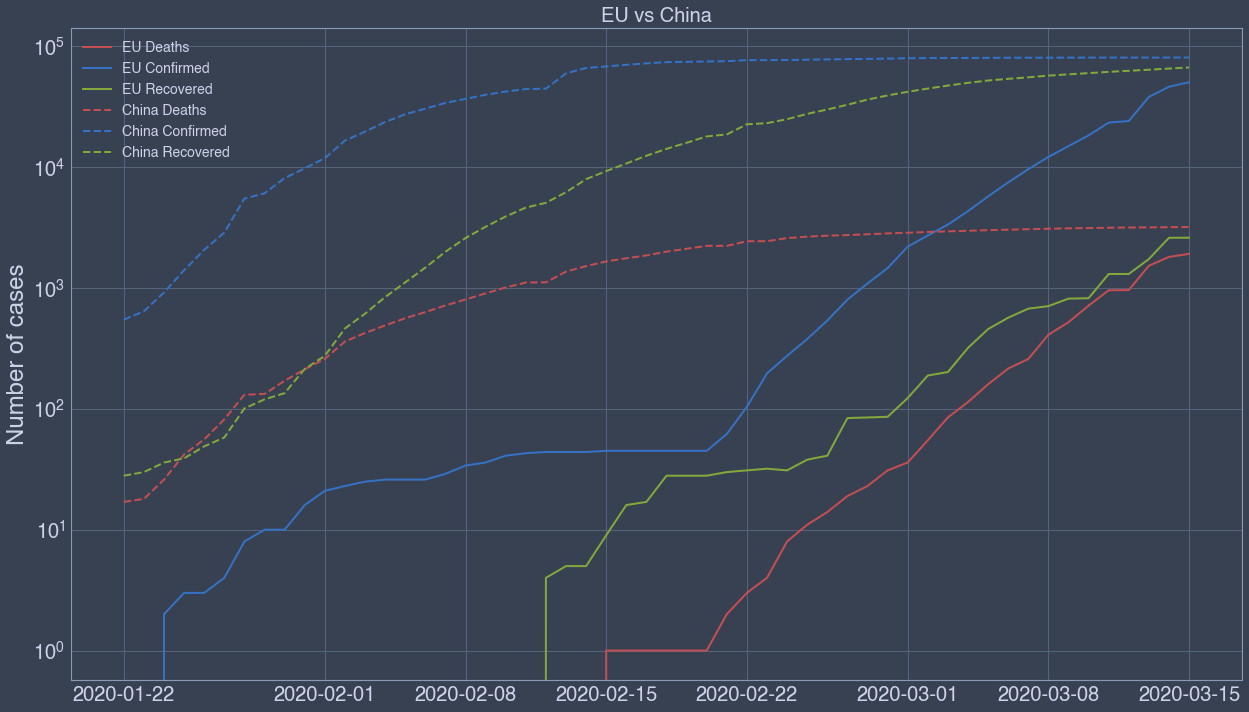

In [333]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-g', linewidth=2, markersize=10, label='EU Recovered')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b', linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '--g', linewidth=2, markersize=10, label='China Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_china.png', dpi = 600, bbox_inches= 'tight')

plt.show()

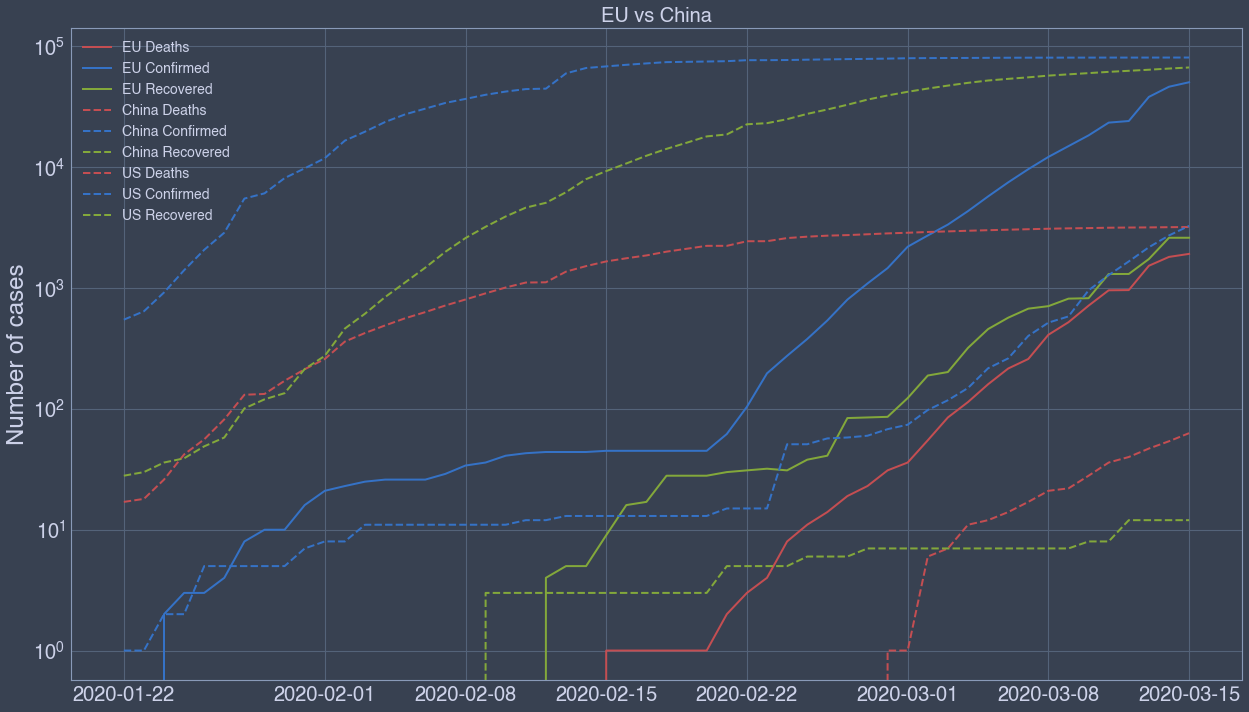

In [334]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-g', linewidth=2, markersize=10, label='EU Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b',  linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '--g',  linewidth=2, markersize=10, label='China Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='US Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b',  linewidth=2, markersize=10, label='US Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Recovered'],
             '--g',  linewidth=2, markersize=10, label='US Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_us_vs_china.png', dpi = 600, bbox_inches= 'tight')
plt.show()

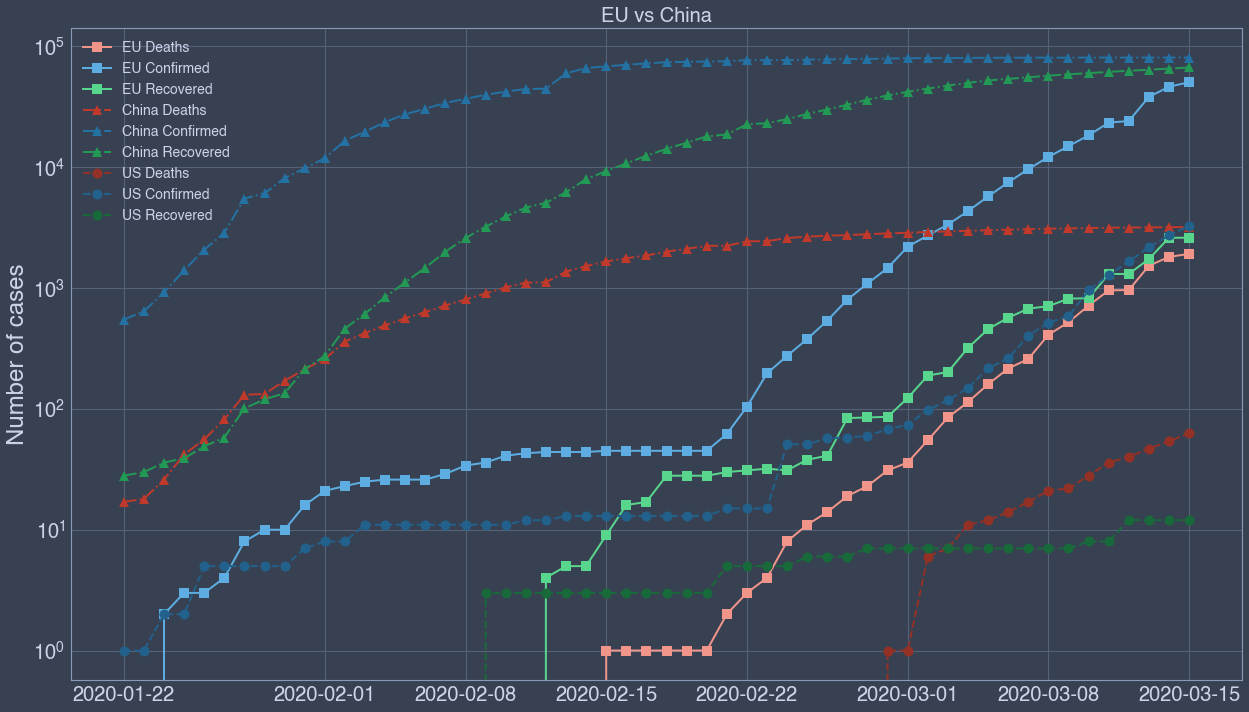

In [319]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-s', color='#F1948A', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-s', color = '#5DADE2', linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-s', color='#58D68D', linewidth=2, markersize=10, label='EU Recovered')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '-.^', color='#C0392B', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '-.^', color='#2471A3', linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '-.^', color='#229954', linewidth=2, markersize=10, label='China Recovered')


plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Deaths'],
             '--o', color='#943126', linewidth=2, markersize=10, label='US Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Confirmed'],
             '--o', color='#21618C', linewidth=2, markersize=10, label='US Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Recovered'],
             '--o', color='#186A3B', linewidth=2, markersize=10, label='US Recovered')

plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

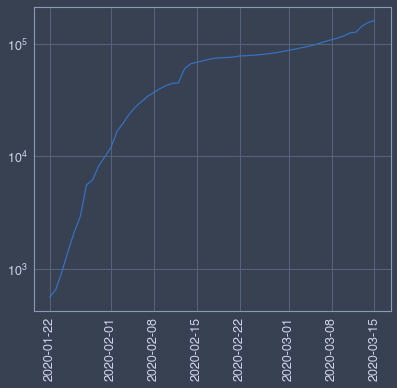

In [326]:
plt.semilogy(df3.groupby('Date').sum().reset_index()['Date'], 
         df3.groupby('Date').sum().reset_index()['Confirmed'])
plt.xticks(rotation = 90)
plt.show()